## ランダムフォレストでやってみた
http://rautaku.hatenablog.com/entry/2017/12/10/000000

In [1]:
import pandas as pd
combats = pd.read_csv('train.csv')
combats.head(3)

,id,First_pokemon,Second_pokemon,Winner
0,0,88,85,85
1,1,466,408,466
2,2,715,120,715


In [3]:
pokemon = pd.read_csv('pokemon.csv')
pokemon_88_85 = pokemon[pokemon['#'].isin([88, 85])]
pokemon_88_85

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
84,85,Rapidash,Fire,NaN,65,100,70,80,80,105,1,False
87,88,Mega Slowbro,Water,Psychic,95,75,180,130,80,30,1,False


Rapidash→ギャロップ
Mega Slowbro→メガヤドラン
### IDを名前に置換

In [4]:
names_dict = dict(zip(pokemon['#'], pokemon['Name']))
cols = ["First_pokemon","Second_pokemon","Winner"]
combats_name = combats[cols].replace(names_dict)
combats_name.head(3)

,First_pokemon,Second_pokemon,Winner
0,Mega Slowbro,Rapidash,Rapidash
1,Buizel,Shelgon,Buizel
2,Keldeo Resolute Forme,Rhyhorn,Keldeo Resolute Forme


### 種族値の分布

count    800.00000
mean     435.10250
std      119.96304
min      180.00000
25%      330.00000
50%      450.00000
75%      515.00000
max      780.00000
Name: stats_sum, dtype: float64


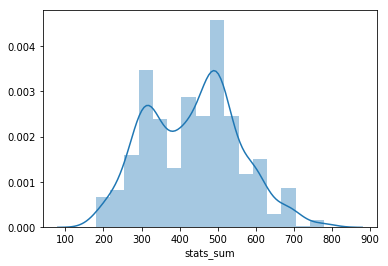

In [5]:
pokemon["stats_sum"] = pokemon["HP"] + pokemon["Attack"] + pokemon["Defense"] + pokemon["Sp. Atk"] + pokemon["Sp. Def"] + pokemon["Speed"]
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print(pokemon["stats_sum"].describe())
sns.distplot(pokemon["stats_sum"])
plt.show()

### 対戦したポケモンの種族値差の分布

count    40000.000000
mean       136.666525
std        101.439660
min          0.000000
25%         54.000000
50%        118.000000
75%        200.000000
max        590.000000
dtype: float64


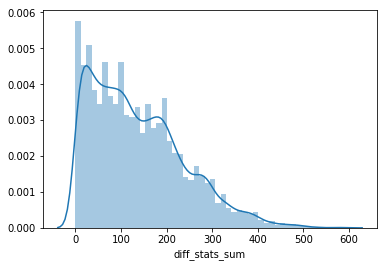

In [6]:
stats_sum_dict = dict(zip(pokemon['#'], pokemon['stats_sum']))
combats_stats_sum = combats[cols].replace(stats_sum_dict)
diff_stats_sum = abs(combats_stats_sum["First_pokemon"]-combats_stats_sum["Second_pokemon"])
print(diff_stats_sum.describe())
sns.distplot(diff_stats_sum)
plt.xlabel("diff_stats_sum")
plt.show()

### 勝者-敗者の種族値分布

count    40000.000000
mean        79.700125
std        150.385977
min       -562.000000
25%        -20.000000
50%         80.000000
75%        185.000000
max        590.000000
dtype: float64


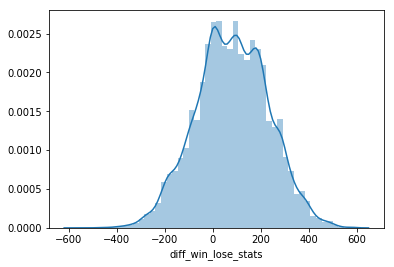

In [7]:
combats_stats_sum["Loser"] = combats_stats_sum.apply(lambda x: x["First_pokemon"] if x["First_pokemon"] !=  x["Winner"] else x["Second_pokemon"], axis = 1)
diff_win_lose_stats = combats_stats_sum["Winner"] - combats_stats_sum["Loser"]
print(diff_win_lose_stats.describe())
sns.distplot(diff_win_lose_stats)
plt.xlabel("diff_win_lose_stats")
plt.show()

### 下克上したやつら

In [8]:
stats_sum_dict_re = dict(zip(pokemon['stats_sum'], pokemon['#']))
combats_stats_sum["diff"] = diff_win_lose_stats
surpassing_stats_sum = combats_stats_sum[combats_stats_sum["diff"] < -100]
print ("Surpassing one's superiors Battle number : " + str(len(surpassing_stats_sum)))
surpassing_id = surpassing_stats_sum[cols].replace(stats_sum_dict_re)
surpassing_name = surpassing_id[cols].replace(names_dict)
surpassing_name.join(combats_stats_sum["diff"]).head(8)

Surpassing one's superiors Battle number : 4588


,First_pokemon,Second_pokemon,Winner,diff
4,Keldeo Resolute Forme,Larvesta,Larvesta,-220
6,Surskit,Vullaby,Surskit,-101
12,Scatterbug,Swadloon,Scatterbug,-180
24,Sawsbuck,Larvesta,Larvesta,-115
40,Klang,Pumpkaboo Super Size,Pumpkaboo Super Size,-105
47,Carbink,Goomy,Goomy,-200
53,Dusclops,Goomy,Goomy,-155
54,Hoopa Unbound,Basculin,Basculin,-220


### 下克上トップ層

In [10]:
surpassing_name.join(combats_stats_sum["diff"]).sort_values(by="diff").head()

,First_pokemon,Second_pokemon,Winner,diff
6639,Mega Rayquaza,Cleffa,Cleffa,-562
11742,Mega Rayquaza,Inkay,Inkay,-492
26793,Arceus,Shedinja,Shedinja,-484
16739,Mega Diancie,Cleffa,Cleffa,-482
16543,Hoopa Unbound,Cleffa,Cleffa,-462


ピィ、マーイーカ、ヌケニンがジャイアントキリングしている

### 先攻後攻の違いで下克上が起きているのか？

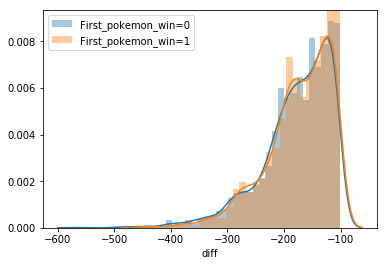

In [11]:
combats_stats_sum["First_Win"] =  combats_stats_sum.apply(lambda x: 1 if x["First_pokemon"] ==  x["Winner"] else 0, axis = 1)
surpassing_stats_sum = combats_stats_sum[combats_stats_sum["diff"] < -100]
sns.distplot(surpassing_stats_sum[surpassing_stats_sum["First_Win"]==0]["diff"], label="First_pokemon_win=0")
sns.distplot(surpassing_stats_sum[surpassing_stats_sum["First_Win"]==1]["diff"], label="First_pokemon_win=1")
plt.legend()
plt.show()

### 全体では先攻後攻で差はあるのか？

-First_Win=0-
count    20822.000000
mean        75.543224
std        152.611847
min       -562.000000
25%        -27.000000
50%         77.000000
75%        185.000000
max        585.000000
Name: diff, dtype: float64
-First_Win=1-
count    19178.000000
mean        84.213369
std        147.803035
min       -445.000000
25%        -13.000000
50%         84.000000
75%        190.000000
max        590.000000
Name: diff, dtype: float64


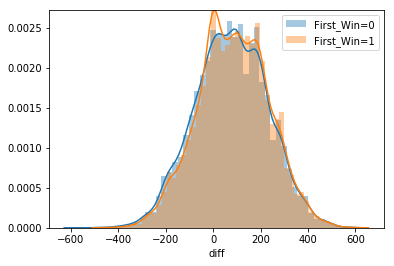

In [12]:
sns.distplot(combats_stats_sum[combats_stats_sum["First_Win"]==0]["diff"], label="First_Win=0")
sns.distplot(combats_stats_sum[combats_stats_sum["First_Win"]==1]["diff"], label="First_Win=1")
print ("-First_Win=0-")
print (combats_stats_sum[combats_stats_sum["First_Win"]==0]["diff"].describe())
print ("-First_Win=1-")
print (combats_stats_sum[combats_stats_sum["First_Win"]==1]["diff"].describe())
plt.legend()
plt.show()

### タイプの種類

In [13]:
print ("There are {} Types.".format(len(pokemon["Type 1"].drop_duplicates())))
list(pokemon["Type 1"].drop_duplicates())

There are 18 Types.


['Grass',
 'Fire',
 'Water',
 'Bug',
 'Normal',
 'Poison',
 'Electric',
 'Ground',
 'Fairy',
 'Fighting',
 'Psychic',
 'Rock',
 'Ghost',
 'Ice',
 'Dragon',
 'Dark',
 'Steel',
 'Flying']

### タイプの組み合わせ

In [14]:
type_cols = ["Type 1", "Type 2"]
print ("There are {} type-combinations.".format(len(pokemon[type_cols].drop_duplicates())))

There are 154 type-combinations.


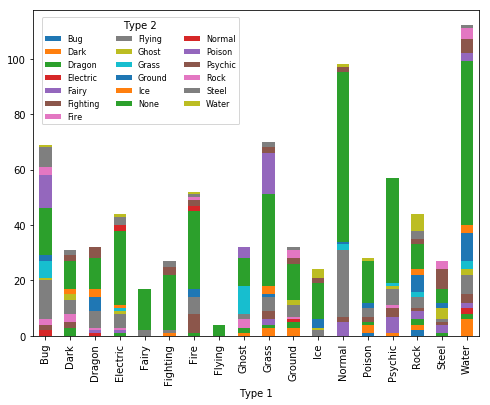

In [15]:
pokemon["Type 2"] = pokemon["Type 2"].fillna("None")
type_cross = pd.crosstab(pokemon["Type 1"], pokemon["Type 2"])
type_cross.plot.bar(stacked=True, figsize=(8,6))
plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', ncol=3, fontsize=8, title="Type 2")
plt.show()

### タイプ相関の数値化

In [16]:
Normal = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 0.5, "Ghost": 0, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Fighting = {"Normal": 2, "Fighting": 1, "Poison": 0.5, "Ground": 1, "Flying": 0.5, "Bug": 0.5, "Rock": 2, "Ghost": 0, "Steel": 2, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 2, "Psychic": 0.5, "Dragon": 1, "Dark": 2, "Fairy": 0.5}
Poison = {"Normal": 1, "Fighting": 1, "Poison": 0.5, "Ground": 0.5, "Flying": 1, "Bug": 1, "Rock": 0.5, "Ghost": 0.5, "Steel": 0, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 2, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 2}
Ground = {"Normal": 1, "Fighting": 1, "Poison": 2, "Ground": 1, "Flying": 0, "Bug": 0.5, "Rock": 2, "Ghost": 1, "Steel": 2, "Fire": 2, "Water": 1, "Electric": 2, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Flying = {"Normal": 1, "Fighting": 2, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 2, "Rock": 0.5, "Ghost": 1, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 0.5, "Grass": 2, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Bug = {"Normal": 1, "Fighting": 0.5, "Poison": 0.5, "Ground": 1, "Flying": 0.5, "Bug": 1, "Rock": 1, "Ghost": 0.5, "Steel": 0.5, "Fire": 0.5, "Water": 1, "Electric": 1, "Grass": 2, "Ice": 1, "Psychic": 2, "Dragon": 1, "Dark": 2, "Fairy": 0.5}
Rock = {"Normal": 1, "Fighting": 0.5, "Poison": 1, "Ground": 0.5, "Flying": 2, "Bug": 2, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 2, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 2, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Ghost = {"Normal": 0, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 2, "Steel": 1, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 2, "Dragon": 1, "Dark": 0.5, "Fairy": 1}
Steel = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 2, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 0.5, "Electric": 0.5, "Grass": 1, "Ice": 2, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 0.5}
Fire = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 2, "Rock": 0.5, "Ghost": 1, "Steel": 2, "Fire": 0.5, "Water": 0.5, "Electric": 1, "Grass": 2, "Ice": 2, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Water = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 2, "Flying": 1, "Bug": 1, "Rock": 2, "Ghost": 1, "Steel": 1, "Fire": 2, "Water": 0.5, "Electric": 1, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Electric = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 0, "Flying": 2, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 1, "Fire": 1, "Water": 2, "Electric": 0.5, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Grass = {"Normal": 1, "Fighting": 1, "Poison": 0.5, "Ground": 2, "Flying": 0.5, "Bug": 0.5, "Rock": 2, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 2, "Electric": 1, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Ice = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 2, "Flying": 2, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 0.5, "Electric": 1, "Grass": 2, "Ice": 0.5, "Psychic": 1, "Dragon": 2, "Dark": 1, "Fairy": 1}
Psychic = {"Normal": 1, "Fighting": 1, "Poison": 2, "Ground": 2, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 0.5, "Dragon": 1, "Dark": 0, "Fairy": 1}
Dragon = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 1, "Dragon": 2, "Dark": 1, "Fairy": 0}
Dark = {"Normal": 1, "Fighting": 0.5, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 2, "Steel": 1, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 2, "Dragon": 1, "Dark": 0.5, "Fairy": 0.5}
Fairy = {"Normal": 1, "Fighting": 2, "Poison": 0.5, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 1, "Dragon": 2, "Dark": 2, "Fairy": 1}

type_relation = {"Normal": Normal, "Fighting": Fighting, "Poison": Poison, "Ground": Ground, "Flying": Flying, "Bug": Bug, "Rock": Rock, "Ghost": Ghost, "Steel": Steel, "Fire": Fire, "Water": Water, "Electric": Electric, "Grass": Grass, "Ice": Ice, "Psychic": Psychic, "Dragon": Dragon, "Dark": Dark, "Fairy": Fairy}
df_type_relation = pd.DataFrame(type_relation)
print ("Row is Diffender, Column is Attacker")
df_type_relation

Row is Diffender, Column is Attacker


,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Bug,1.0,1.0,1.0,1.0,1.0,0.5,2.0,2.0,1.0,0.5,0.5,1.0,1.0,1.0,1.0,2.0,1.0,1.0
Dark,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Dragon,1.0,1.0,2.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5
Electric,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Fairy,0.5,0.5,0.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,1.0
Fighting,0.5,0.5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0
Fire,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0
Flying,0.5,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0,0.5,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
Ghost,0.5,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.5,1.0,1.0,1.0,1.0
Grass,2.0,1.0,1.0,0.5,1.0,1.0,2.0,2.0,1.0,0.5,0.5,2.0,1.0,2.0,1.0,1.0,1.0,0.5


### タイプの勝敗への影響

count    40000.000000
mean         1.144876
std          0.868061
min          0.031250
25%          0.500000
50%          1.000000
75%          1.000000
max         16.000000
Name: Relation, dtype: float64


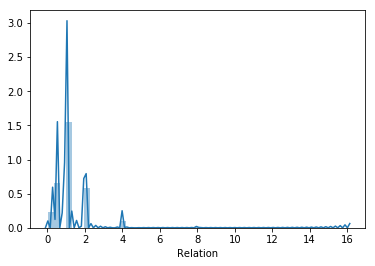

In [17]:
pokemon["Type"] = pokemon.apply(lambda x: x["Type 1"]+"/"+x["Type 2"], axis=1)
type_dict = dict(zip(pokemon['#'], pokemon['Type']))
combats_type = combats[cols].replace(type_dict)
combats_type["Loser"] = combats_type.apply(lambda x: x["First_pokemon"] if x["First_pokemon"] !=  x["Winner"] else x["Second_pokemon"], axis = 1)

zero_dict = {0: 0.25}
df_type_relation = df_type_relation[:].replace(zero_dict)

def calcRelation(combats_type):
    r0 = 1
    win_type1 = combats_type["Winner"].split("/")[0]
    win_type2 = combats_type["Winner"].split("/")[1]
    lose_type1 = combats_type["Loser"].split("/")[0]
    lose_type2 = combats_type["Loser"].split("/")[1]
    if win_type2 != "None" and lose_type2 != "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r2 = df_type_relation[win_type1][lose_type2]
        r3 = df_type_relation[win_type2][lose_type1]
        r4 = df_type_relation[win_type2][lose_type2]
        r = r0 * r1 * r2 * r3 * r4
    elif win_type2 != "None" and lose_type2 == "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r3 = df_type_relation[win_type2][lose_type1]
        r = r0 * r1 * r3
    elif win_type2 == "None" and lose_type2 != "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r2 = df_type_relation[win_type1][lose_type2]
        r = r0 * r1 * r2
    elif win_type2 == "None" and lose_type2 == "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r = r0 * r1
    return r

combats_type["Relation"] = combats_type.apply(lambda x: calcRelation(x), axis = 1)
print (combats_type["Relation"].describe())
sns.distplot(combats_type["Relation"])
plt.show()

### 勝率の高いポケモン

In [20]:
combats_names = combats[cols].replace(names_dict)
first_num = combats_names["First_pokemon"].value_counts()
second_num = combats_names["Second_pokemon"].value_counts()
battle_num = first_num + second_num
battle_win = pd.DataFrame({"battle": battle_num, "win": combats_names["Winner"].value_counts()}, columns=["battle", "win"])
battle_win["ratio"] = battle_win["win"]/battle_win["battle"]
battle_win.sort_values(by=["ratio"], ascending=False).head(10)

,battle,win,ratio
Mega Aerodactyl,106,104.0,0.981132
Mega Lopunny,97,95.0,0.979381
Mega Beedrill,91,89.0,0.978022
Mega Sceptile,102,99.0,0.970588
Weavile,96,93.0,0.968750
Tornadus Therian Forme,94,91.0,0.968085
Darkrai,91,88.0,0.967033
Aerodactyl,111,107.0,0.963964
Meloetta Pirouette Forme,100,96.0,0.960000
Mega Sharpedo,93,89.0,0.956989


### 欠損値処理

In [21]:
battle_win[battle_win["win"].isnull()]

,battle,win,ratio
Shuckle,109,NaN,NaN


In [22]:
battle_win.ix["Shuckle", ["win", "ratio"]] = 0
battle_win[battle_win.index=="Shuckle"]

/Users/yutohagiwara/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,battle,win,ratio
Shuckle,109,0.0,0.0


### 勝率を種族値の線形回帰で補完

In [23]:
id_dict = dict(zip(pokemon['Name'], pokemon['#']))
battle_win["Name"] = battle_win.index
battle_win["#"] = battle_win["Name"].replace(id_dict)
ratio_dict = dict(zip(battle_win['#'], battle_win['ratio']))
pokemon["ratio"] = pokemon["#"].replace(ratio_dict)
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,stats_sum,Type,ratio
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318,Grass/Poison,0.284404
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405,Grass/Poison,0.417476
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525,Grass/Poison,0.657895
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625,Grass/Poison,0.547170
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,309,Fire/None,0.489130


In [24]:
nobattle_pokemon = pokemon[pokemon["ratio"]>1]
print ("There are {} pokemons have NaN ratio.".format(len(nobattle_pokemon.index)))
nobattle_pokemon[["#", "Name", "ratio"]]

There are 17 pokemons have NaN ratio.


,#,Name,ratio
11,12,Blastoise,12.0
32,33,Sandshrew,33.0
45,46,Wigglytuff,46.0
62,63,NaN,63.0
65,66,Poliwag,66.0
77,78,Victreebel,78.0
89,90,Magneton,90.0
143,144,Ditto,144.0
182,183,Ariados,183.0
235,236,Ursaring,236.0


In [25]:
pokemon.loc[62, "Name"] = "Primeape"
pokemon[pokemon["Name"]=="Primeape"][["#", "Name", "ratio"]]

,#,Name,ratio
62,63,Primeape,63.0


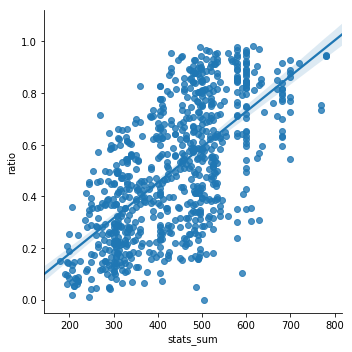

In [26]:
battle_pokemon = pokemon[pokemon["ratio"] <= 1]
sns.lmplot(x="stats_sum", y="ratio", data=battle_pokemon)

In [27]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(battle_pokemon["stats_sum"].values.reshape(-1, 1), battle_pokemon["ratio"].values.reshape(-1, 1))
nobattle_pokemon["ratio"] = linreg.predict(nobattle_pokemon["stats_sum"].values.reshape(-1, 1))
nobattle_pokemon[["#", "Name", "ratio"]]

/Users/yutohagiwara/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,#,Name,ratio
11,12,Blastoise,0.631953
32,33,Sandshrew,0.315077
45,46,Wigglytuff,0.501069
62,63,NaN,0.528624
65,66,Poliwag,0.315077
77,78,Victreebel,0.576844
89,90,Magneton,0.542401
143,144,Ditto,0.298545
182,183,Ariados,0.439072
235,236,Ursaring,0.590621


### 各種族値やタイプ相性などのデータをマージ

In [28]:
combats_add_data = combats.copy()
type_dict = dict(zip(pokemon['#'], pokemon['Type']))
hp_dict = dict(zip(pokemon['#'], pokemon['HP']))
attack_dict = dict(zip(pokemon['#'], pokemon['Attack']))
defense_dict = dict(zip(pokemon['#'], pokemon['Defense']))
spattack_dict = dict(zip(pokemon['#'], pokemon['Sp. Atk']))
spdefense_dict = dict(zip(pokemon['#'], pokemon['Sp. Def']))
speed_dict = dict(zip(pokemon['#'], pokemon['Speed']))
stats_sum_dict = dict(zip(pokemon['#'], pokemon['stats_sum']))
ratio_dict = dict(zip(pokemon['#'], pokemon['ratio']))
combats_add_data["First_pokemon_type"] = combats_add_data["First_pokemon"].replace(type_dict)
combats_add_data["First_pokemon_hp"] = combats_add_data["First_pokemon"].replace(hp_dict)
combats_add_data["First_pokemon_attack"] = combats_add_data["First_pokemon"].replace(attack_dict)
combats_add_data["First_pokemon_defense"] = combats_add_data["First_pokemon"].replace(defense_dict)
combats_add_data["First_pokemon_spattack"] = combats_add_data["First_pokemon"].replace(spattack_dict)
combats_add_data["First_pokemon_spdefense"] = combats_add_data["First_pokemon"].replace(spdefense_dict)
combats_add_data["First_pokemon_speed"] = combats_add_data["First_pokemon"].replace(speed_dict)
combats_add_data["First_pokemon_stats"] = combats_add_data["First_pokemon"].replace(stats_sum_dict)
combats_add_data["First_pokemon_ratio"] = combats_add_data["First_pokemon"].replace(ratio_dict)
combats_add_data["Second_pokemon_type"] = combats_add_data["Second_pokemon"].replace(type_dict)
combats_add_data["Second_pokemon_hp"] = combats_add_data["Second_pokemon"].replace(hp_dict)
combats_add_data["Second_pokemon_attack"] = combats_add_data["Second_pokemon"].replace(attack_dict)
combats_add_data["Second_pokemon_defense"] = combats_add_data["Second_pokemon"].replace(defense_dict)
combats_add_data["Second_pokemon_spattack"] = combats_add_data["Second_pokemon"].replace(spattack_dict)
combats_add_data["Second_pokemon_spdefense"] = combats_add_data["Second_pokemon"].replace(spdefense_dict)
combats_add_data["Second_pokemon_speed"] = combats_add_data["Second_pokemon"].replace(speed_dict)
combats_add_data["Second_pokemon_stats"] = combats_add_data["Second_pokemon"].replace(stats_sum_dict)
combats_add_data["Second_pokemon_ratio"] = combats_add_data["Second_pokemon"].replace(ratio_dict)


def calcTypeRelation(combats_add_data):
    r0 = 1
    first_type1 = combats_add_data["First_pokemon_type"].split("/")[0]
    first_type2 = combats_add_data["First_pokemon_type"].split("/")[1]
    second_type1 = combats_add_data["Second_pokemon_type"].split("/")[0]
    second_type2 = combats_add_data["Second_pokemon_type"].split("/")[1]
    if first_type2 != "None" and second_type2 != "None":
        r1 = df_type_relation[first_type1][second_type1]
        r2 = df_type_relation[first_type1][second_type2]
        r3 = df_type_relation[first_type2][second_type1]
        r4 = df_type_relation[first_type2][second_type2]
        r = r0 * r1 * r2 * r3 * r4
    elif first_type2 != "None" and second_type2 == "None":
        r1 = df_type_relation[first_type1][second_type1]
        r3 = df_type_relation[first_type2][second_type1]
        r = r0 * r1 * r3
    elif first_type2 == "None" and second_type2 != "None":
        r1 = df_type_relation[first_type1][second_type1]
        r2 = df_type_relation[first_type1][second_type2]
        r = r0 * r1 * r2
    elif first_type2 == "None" and second_type2 == "None":
        r1 = df_type_relation[first_type1][second_type1]
        r = r0 * r1
    return r

combats_add_data["Relation"] = combats_add_data.apply(lambda x: calcTypeRelation(x), axis = 1)
combats_add_data["First_win"] = combats_add_data.apply(lambda x: 1 if x["First_pokemon"]==x["Winner"] else 0, axis=1)
noneed_cols = ["First_pokemon", "Second_pokemon", "Winner", "First_pokemon_type", "Second_pokemon_type"]
combats_add_data = combats_add_data.drop(noneed_cols, axis=1)
combats_add_data.head()

,id,First_pokemon_hp,First_pokemon_attack,First_pokemon_defense,First_pokemon_spattack,First_pokemon_spdefense,First_pokemon_speed,First_pokemon_stats,First_pokemon_ratio,Second_pokemon_hp,Second_pokemon_attack,Second_pokemon_defense,Second_pokemon_spattack,Second_pokemon_spdefense,Second_pokemon_speed,Second_pokemon_stats,Second_pokemon_ratio,Relation,First_win
0,0,95,75,180,130,80,30,590,0.103093,65,100,70,80,80,105,500,0.852273,2.0,0
1,1,55,65,35,60,30,85,330,0.662500,65,95,100,60,50,50,420,0.343434,0.5,1
2,2,91,72,90,129,90,108,580,0.888889,80,85,95,30,30,25,345,0.280899,8.0,1
3,3,85,105,55,85,50,115,495,0.897959,60,70,105,70,120,75,500,0.557895,2.0,1
4,4,80,50,100,100,200,50,580,0.240385,55,70,55,40,55,85,360,0.686275,1.0,0


### ホールドアウト

In [29]:
from sklearn.model_selection import train_test_split

X = combats_add_data.drop("First_win", axis=1)
y = combats_add_data["First_win"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
print("X_train.shape = " + str(X_train.shape))
print("X_test.shape = " + str(X_test.shape))
print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))

X_train.shape = (32000, 18)
X_test.shape = (8000, 18)
y_train.shape = (32000,)
y_test.shape = (8000,)


/Users/yutohagiwara/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### ロジスティック回帰

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(logreg.score(X_test, y_test)*100, 2)
acc_log

88.16

### k近傍法

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
acc_knn = round(knn.score(X_test, y_test) * 100, 2)
acc_knn

70.7

### ガウシアンナイーブベイズ

In [32]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
acc_gaussian = round(gaussian.score(X_test, y_test) * 100, 2)
acc_gaussian

77.15

### パーセプトロン

In [33]:
# Perceptron
from sklearn.linear_model import Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
acc_perceptron = round(perceptron.score(X_test, y_test) * 100, 2)
acc_perceptron

/Users/yutohagiwara/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


64.9

### 決定木

In [34]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
acc_decision_tree

92.31

### ランダムフォレスト

In [35]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
acc_random_forest

94.44

### 勾配ブースティング木

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
gbct = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.1)
gbct.fit(X_train, y_train)
acc_gbct = round(gbct.score(X_test,y_test)*100,2)
acc_gbct

91.1

### 結果

In [37]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 
              'Naive Bayes', 'Perceptron', 'Decision Tree', 'Random Forest','GradientBoostingClassifier'],
    'Score': [acc_log, acc_knn, acc_gaussian, acc_perceptron, 
              acc_decision_tree, acc_random_forest, acc_gbct]})
models.sort_values(by='Score', ascending=False)

,Model,Score
5,Random Forest,94.44
4,Decision Tree,92.31
6,GradientBoostingClassifier,91.10
0,Logistic Regression,88.16
2,Naive Bayes,77.15
1,KNN,70.70
3,Perceptron,64.90


### ランダムフォレストで見る重要度

In [38]:
effective = pd.DataFrame()
effective["feature_name"] = X.columns.tolist()
effective["feature_importance"] = random_forest.feature_importances_
effective.sort_values("feature_importance",ascending=False)

,feature_name,feature_importance
8,First_pokemon_ratio,0.184031
14,Second_pokemon_speed,0.172550
6,First_pokemon_speed,0.169142
16,Second_pokemon_ratio,0.168130
7,First_pokemon_stats,0.040974
15,Second_pokemon_stats,0.038555
10,Second_pokemon_attack,0.024812
2,First_pokemon_attack,0.024086
17,Relation,0.020781
4,First_pokemon_spattack,0.019606


In [41]:
X.head()

,id,First_pokemon_hp,First_pokemon_attack,First_pokemon_defense,First_pokemon_spattack,First_pokemon_spdefense,First_pokemon_speed,First_pokemon_stats,First_pokemon_ratio,Second_pokemon_hp,Second_pokemon_attack,Second_pokemon_defense,Second_pokemon_spattack,Second_pokemon_spdefense,Second_pokemon_speed,Second_pokemon_stats,Second_pokemon_ratio,Relation
0,0,95,75,180,130,80,30,590,0.103093,65,100,70,80,80,105,500,0.852273,2.0
1,1,55,65,35,60,30,85,330,0.662500,65,95,100,60,50,50,420,0.343434,0.5
2,2,91,72,90,129,90,108,580,0.888889,80,85,95,30,30,25,345,0.280899,8.0
3,3,85,105,55,85,50,115,495,0.897959,60,70,105,70,120,75,500,0.557895,2.0
4,4,80,50,100,100,200,50,580,0.240385,55,70,55,40,55,85,360,0.686275,1.0


In [42]:
test = pd.read_csv('test.csv')
test.head(3)

,id,First_pokemon,Second_pokemon
0,0,85,602
1,1,536,155
2,2,189,644


In [45]:
combats_add_data2 = test.copy()
type_dict = dict(zip(pokemon['#'], pokemon['Type']))
hp_dict = dict(zip(pokemon['#'], pokemon['HP']))
attack_dict = dict(zip(pokemon['#'], pokemon['Attack']))
defense_dict = dict(zip(pokemon['#'], pokemon['Defense']))
spattack_dict = dict(zip(pokemon['#'], pokemon['Sp. Atk']))
spdefense_dict = dict(zip(pokemon['#'], pokemon['Sp. Def']))
speed_dict = dict(zip(pokemon['#'], pokemon['Speed']))
stats_sum_dict = dict(zip(pokemon['#'], pokemon['stats_sum']))
ratio_dict = dict(zip(pokemon['#'], pokemon['ratio']))
combats_add_data2["First_pokemon_type"] = combats_add_data2["First_pokemon"].replace(type_dict)
combats_add_data2["First_pokemon_hp"] = combats_add_data2["First_pokemon"].replace(hp_dict)
combats_add_data2["First_pokemon_attack"] = combats_add_data2["First_pokemon"].replace(attack_dict)
combats_add_data2["First_pokemon_defense"] = combats_add_data2["First_pokemon"].replace(defense_dict)
combats_add_data2["First_pokemon_spattack"] = combats_add_data2["First_pokemon"].replace(spattack_dict)
combats_add_data2["First_pokemon_spdefense"] = combats_add_data2["First_pokemon"].replace(spdefense_dict)
combats_add_data2["First_pokemon_speed"] = combats_add_data2["First_pokemon"].replace(speed_dict)
combats_add_data2["First_pokemon_stats"] = combats_add_data2["First_pokemon"].replace(stats_sum_dict)
combats_add_data2["First_pokemon_ratio"] = combats_add_data2["First_pokemon"].replace(ratio_dict)
combats_add_data2["Second_pokemon_type"] = combats_add_data2["Second_pokemon"].replace(type_dict)
combats_add_data2["Second_pokemon_hp"] = combats_add_data2["Second_pokemon"].replace(hp_dict)
combats_add_data2["Second_pokemon_attack"] = combats_add_data2["Second_pokemon"].replace(attack_dict)
combats_add_data2["Second_pokemon_defense"] = combats_add_data2["Second_pokemon"].replace(defense_dict)
combats_add_data2["Second_pokemon_spattack"] = combats_add_data2["Second_pokemon"].replace(spattack_dict)
combats_add_data2["Second_pokemon_spdefense"] = combats_add_data2["Second_pokemon"].replace(spdefense_dict)
combats_add_data2["Second_pokemon_speed"] = combats_add_data2["Second_pokemon"].replace(speed_dict)
combats_add_data2["Second_pokemon_stats"] = combats_add_data2["Second_pokemon"].replace(stats_sum_dict)
combats_add_data2["Second_pokemon_ratio"] = combats_add_data2["Second_pokemon"].replace(ratio_dict)


combats_add_data2["Relation"] = combats_add_data2.apply(lambda x: calcTypeRelation(x), axis = 1)
#combats_add_data2["First_win"] = combats_add_data2.apply(lambda x: 1 if x["First_pokemon"]==x["Winner"] else 0, axis=1)
noneed_cols = ["First_pokemon", "Second_pokemon", "First_pokemon_type", "Second_pokemon_type"]
combats_add_data2 = combats_add_data2.drop(noneed_cols, axis=1)
combats_add_data2.head()

,id,First_pokemon_hp,First_pokemon_attack,First_pokemon_defense,First_pokemon_spattack,First_pokemon_spdefense,First_pokemon_speed,First_pokemon_stats,First_pokemon_ratio,Second_pokemon_hp,Second_pokemon_attack,Second_pokemon_defense,Second_pokemon_spattack,Second_pokemon_spdefense,Second_pokemon_speed,Second_pokemon_stats,Second_pokemon_ratio,Relation
0,0,65,100,70,80,80,105,500,0.852273,55,63,90,50,80,42,380,0.219780,4.0
1,1,50,65,107,105,107,86,520,0.750000,80,135,85,70,95,150,615,0.981132,1.0
2,2,90,30,15,40,20,15,210,0.052632,36,50,50,65,60,44,305,0.166667,1.0
3,3,85,80,70,135,75,90,535,0.715517,100,100,100,100,100,100,600,0.844444,1.0
4,4,100,123,75,57,75,80,510,0.688000,78,92,75,74,63,118,500,0.877551,2.0


In [46]:
Test = combats_add_data2

In [47]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest_2 = RandomForestClassifier(n_estimators=100)
random_forest_2.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
random_forest_2.predict_proba(Test)

array([[0.05, 0.95],
       [0.95, 0.05],
       [0.91, 0.09],
       ...,
       [0.01, 0.99],
       [0.88, 0.12],
       [0.81, 0.19]])

In [77]:
predict = random_forest_2.predict_proba(Test)
predict

array([[0.05, 0.95],
       [0.95, 0.05],
       [0.91, 0.09],
       ...,
       [0.01, 0.99],
       [0.88, 0.12],
       [0.81, 0.19]])

In [78]:
np.savetxt('output2.csv',predict,delimiter=',')